# The full python workflow for semasiological token-level clouds 

This notebook shows the full workflow followed to create the clouds in Chapter 5 of the monograph (and my dissertation).

(Eventually, add Kris's chapter too)

For this purpose I'm creating a Python package with more order than my previous attempts. It is called `semasioFlow` and has the most verbose code; its documentation can be explored [here](docs/build/html/index.html).

## 0. Initial setup 

So first we have to add this directory to the path in order to import `semasioFlow`. When it initializes, it loads other libraries we need as well as the `qlvl` library from the `depmodel` repository.

In [1]:
import os
import sys
mypackage = "/home/projects/semmetrix/mariana_wolken/cleanWorkflow/scripts/"
#qlvldir = "/home/mariana/repos/enzocxt/depmodel/"
sys.path.append(mypackage)

In [2]:
from semasioFlow import ConfigLoader
from semasioFlow.load import loadVocab, loadMacro, loadColloc, loadFocRegisters
from semasioFlow.sample import sampleTypes
from semasioFlow.focmodels import createBow, createRel, createPath
from semasioFlow.socmodels import targetPPMI, weightTokens, createSoc
from semasioFlow.utils import plotPatterns

## 1. Configuration 

Depending on what you need, you will have to set up some useful paths settings.
I like to have at least the path to my project (`mydir`), an output path within (`mydir + "output"`) and a GitHub path for the datasets that I will use in the visualization. There is no real reason not to have everything together, except that I did not think of it at the moment. (Actually, there is: the GitHub stuff will be public and huge data would not be included. How much do we want to have public?)

In [3]:
mydir = "/home/projects/semmetrix/mariana_wolken/cleanWorkflow/"
output_path = f"{mydir}/output/"
github_dir = f"{mydir}/github/"

The variables with paths is just meant to make it easier to manipulate filenames. The most important concrete step is to adapt the configuration file.

In [4]:
conf = ConfigLoader()
default_settings = conf.settings
settings = default_settings
# Regular expression to capture data from the QLVLNewsCorpus
settings['line-machine'] = '([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)\t_\t_'
settings['separator-line-machine'] = "^</sentence>$"
settings['global-columns'] = "id,word,lemma,pos,head,deprel"
settings['note-attr'] = 'word,lemma,pos'
settings['edge-attr'] = 'deprel'
settings['currID'] = 'id'
settings['headID'] = 'head'
settings['type'] = 'lemma/pos'
settings['colloc'] = 'lemma/pos'
settings['token'] = 'lemma/pos/fid/lid'

settings['file-encoding'] = 'latin1'
settings['outfile-encoding'] = 'utf-8'
settings['output-path'] = output_path
settings['corpus-path'] = '/home/aardvark/corp/nl/'

print(settings['line-machine'])
print(settings['global-columns'])
print(settings['type'], settings['colloc'], settings['token'])

([^	]+)	([^	]+)	([^	]+)	([^	]+)	([^	]+)	([^	]+)	_	_
id,word,lemma,pos,head,deprel
lemma/pos lemma/pos lemma/pos/fid/lid


## 2. Frequency lists

The frequency lists are the first thing to create, but once you have them, you just load them. So what we are going to do here is define the filename where we *would* store the frequency list (in this case, where it is actually stored), and if it exists it loads it; if it doesn't, it creates and store it.

In [5]:
full_name = f"{output_path}/vocab/QLVLNews.nodefreq"
print(full_name)
full = loadVocab(full_name, settings)
full

/home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//vocab/QLVLNews.nodefreq
Loading existing vocabulary...


[('./punct', 28225482),('de/det', 28074105),(',/punct', 18092245) ... ('België-VTS/name', 1),('fertility/name', 1),('appelerend/adj', 1)]

In [6]:
foc_name = f"{output_path}/vocab/QLVLNews.FOC.nodefreq"
print(foc_name)
foc = loadVocab(foc_name, settings)
foc

/home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//vocab/QLVLNews.FOC.nodefreq
Loading existing vocabulary...


[('de/det', 28074105),('van/prep', 12638933),('het/det', 11650779) ... ('Uitbergen/name', 227),('provincie_weg/noun', 227),('Jommeke/name', 227)]

In [7]:
soc_name = f"{output_path}/vocab/QLVLNews.contextwords_final.nodefreq"
print(soc_name)
soc = loadVocab(soc_name, settings)
soc

/home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//vocab/QLVLNews.contextwords_final.nodefreq
Loading existing vocabulary...


[('ben/verb', 9938754),('heb/verb', 4034811),('word/verb', 3486710) ... ('intergouvernementeel/adj', 337),('verdrinking/noun', 337),('popcorn/noun', 336)]

## 3. Boolean token-level matrices

Even though we first think of the type leven and only afterwards of the token level, with this workflow we don't really need to touch type level until after we obtain the boolean token-level matrices, that is, until we need to use PPMI values to select or weight the context words.

As a first step, we need the type or list of types we want to run; for example `"heet/adj"` or `["vernietig/verb", "verniel/verb"]`, and we subset the vocabulary for that query.

In [8]:
fnames = f"{mydir}/sources/LeNC260TwNC260.fnames"

In [9]:
query = full.subvocab(["verniel/verb", "vernietig/verb"])
type_name = "destroy"
query

[('verniel/verb', 7507),('vernietig/verb', 12128)]

We could generate the tokens for all 10k tokens, or create a random selection with a certain number and then only use those files. The output of sampleTypes includes a list of token IDs as well as the list of filenames that suffices to extract those tokens. We can then use the new list of filenames when we collect tokens, and the list of tokens to subset the resulting matrices.

Of course, to keep the sample fixed it would be more useful to generate the list, store it and then retrieve it in future runs.

In [10]:
import json
import os.path

tokenlist_fname = f"{mydir}/sources/destroy.json" # original file
# tokenlist_fname = f"{mydir}/sources/filelist.json" # subset of 8
if os.path.exists(tokenlist_fname):
    with open(tokenlist_fname, "r") as f:
        tokenlist, fnameSample = json.load(f).values()
else:
    tokenlist, fnameSample = sampleTypes({"eet/verb" : 30, "drink/verb" : 30}, fnames)
    with open(tokenlist_fname, "w") as f:
        json.dump({"tokenlist" : tokenlist, "fnames" : fnameSample}, f)

In [11]:
len(tokenlist)

486

### 3.1 Bag-of-words

The code to generate one matrix is very straightforward, but what if we want to use different combinations of parameter settings to create multiple matrices?

The code below assumes that the boolean BOW matrices may vary across three parameters:

- **foc_win**: window size, which is set with numbers for let and right window. *This has the settings above for default*
- **foc_pos**: part-of-speech filter, which will actually be set as a previously filtered list of context words. *By default, all context words are included.*
- **bound**: the match for sentence boundaries and whether the models respond to them or not. *By default, sentence boundaries are ignored.*

In [ ]:
lex_pos = [x for x in foc.get_item_list() if x.split("/")[1] in ["noun", "adj", "verb", "adv"]]

In [ ]:
foc_win = [(3, 3), (5, 5), (10, 10)] #three options of symmetric windows with 3, 5 or 10 words to each side
foc_pos = {
    "all" : foc.get_item_list(), # the filter has already been applied in the FOC list
    "lex" : lex_pos # further filter by part-of-speech
}
bound = { "match" : "^</sentence>$", "values" : [True, False]}

The function below combines a number of necessary functions:

- it creates a loop over the different combinations of parameter settings specified
- it collects the tokens and computes and filters the corresponding matrices
- it transforms the matrices in "boolean" integer matrices, with only 0's and 1's
- it stores the matrices in their respective files
- it records the combinations of parameter settings and which values are taken by each model
- it records the context words captured by each model for each token
- it returns both records to be stored wherever you want

In [ ]:
bowdata = createBow(query, settings, type_name = type_name, fnames = fnameSample, tokenlist = tokenlist,
        foc_win = foc_win, foc_pos = foc_pos, bound = bound)
bowdata.to_csv(f"{output_path}/registers/{type_name}.bow-models.tsv", sep = "\t", index_label = "_model")

In [ ]:
bowdata

If you have many lemmas (like I did) you would want to have code like the following:

In [ ]:
# # 1. Set up the names of your types and the selection for the query ================================
# adj_lemmas = ['heilzaam', 'hoekig', 'gekleurd', 'dof', 'hachelijk', 'geestig', 'hoopvol',
#               'hemels', 'geldig', 'gemeen', 'goedkoop', 'grijs', 'heet']
# only_adjs = [(x, [x+'/adj']) for x in adj_lemmas]

# # 2. Load token ID list, which is what I had, but the json path above makes sense too ==============
# with open(f"{mydir}/sources/adjIds.txt", 'r') as s:
#     adjs = [x.strip() for x in s.readlines()]

# # 3. Extract filenames from token ID's and map to paths ================================
# token2fname = [x.split('/')[2]+'.conll' for x in adjs]
# with open(fnames, 'r') as q:
#     fnameSample = [x.strip() for x in q.readlines() if x.strip().rsplit('/', 1)[1] in token2fname]
    
# # 4. On a loop per item, row create Bow ================================
# for type_name, query_list in only_adjs:
#     query = full.subvocab(query_list)
#     bowdata = createBow(query, settings, type_name = type_name, fnames = fnameSample, tokenlist = adjs,
#          foc_win = foc_win, foc_pos = foc_pos, bound = bound)
    
#     # 5. Most probably, store register ================================
#     models_fname = f"{output_path}/registers/{type_name}.bow-models.tsv"
#     bowdata.to_csv(models_fname, sep="\t", index_label = '_model')

### 3.2 Lemmarel

For dependency models we need specific templates and and patterns --- especially for LEMMAREL, they need to be tailored to the part-of-speech that you are looking into. Since I'm exemplifying with a verb, I will use those templates.

**IMPORTANT**: In order to work, dependency models require the 'separator-line-machine' value.

**Note**: The old code used a lot of upper case; these copies of templates use only lower case. I will soon fix that in the other templates and move them to this directory.

In [12]:
graphml_name = "LEMMAREL.verbs"
templates_dir = f"{mydir}/templates"
rel_macros = [
    ("LEMMAREL1", loadMacro(templates_dir, graphml_name, "LEMMAREL1.verbs")),
    ("LEMMAREL2", loadMacro(templates_dir, graphml_name, "LEMMAREL2.verbs"))
]
settings['separator-line-machine'] = "^</sentence>$"

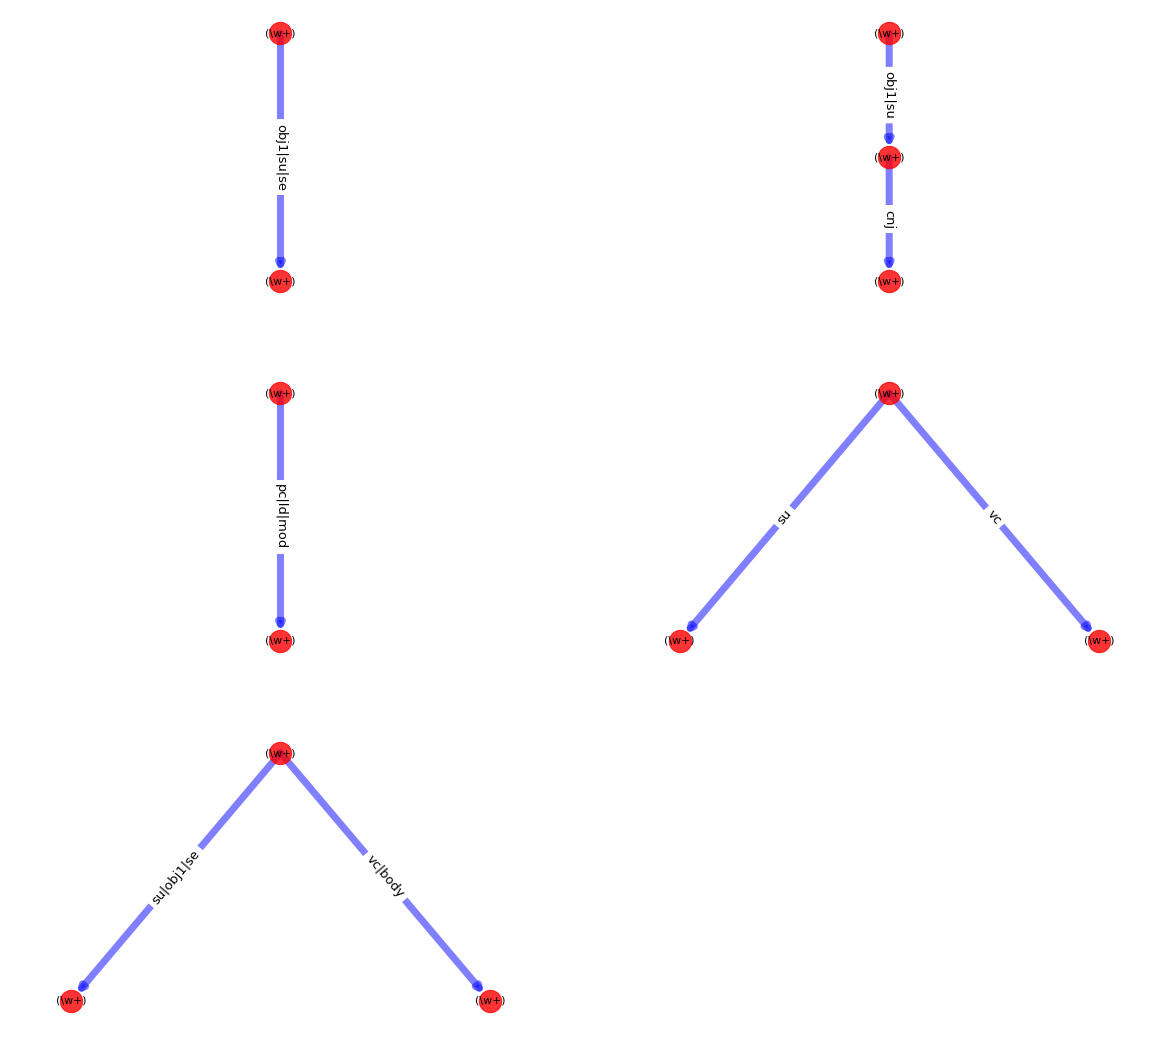

In [13]:
# The objects returned by loadMacro can be plotted:
plotPatterns(rel_macros[0][1])

In [14]:
reldata = createRel(query, settings, rel_macros, type_name = type_name,
              fnames = fnameSample, tokenlist = tokenlist, foc_filter = foc.get_item_list())
reldata.to_csv(f"{output_path}/registers/{type_name}.rel-models.tsv", sep = "\t", index_label = "_model")

Building dependency features...



Building matrix...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.LEMMAREL1.tcmx.bool.pac
Building dependency features...



Building matrix...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.LEMMAREL2.tcmx.bool.pac


In [ ]:
# # 6. On a loop per item, row create Path ================================
# for type_name, query_list in only_adjs:
#     query = full.subvocab(query_list)
#     reldata = createRel(query, settings, rel_macros, type_name = type_name,
#                         fnames = fnameSample, tokenlist = adjs, foc_filter = foc.get_item_list())
    
#     # 7. Most probably, store register ================================
#     models_fname = f"{output_path}/registers/{type_name}.rel-models.tsv"
#     reldata.to_csv(models_fname, sep="\t", index_label = '_model')

### 3.3 Lemmapath

Like LEMMAREL, the LEMMAPATH models need 'separator-line-machine' to be properly set and the templates to be loaded.
Unlike LEMMAREL, the templates are not cumulative: LEMMAPATH1 models only cover those with one step between target and context word, while LEMMAPATH2 covers those with two steps. We *could* make them cumulative, but this setup allows us to give them different weights in PATHweight models.

In [ ]:
graphml_name = "LEMMAPATH"
templates_dir = f"{mydir}/templates"
path_templates = [loadMacro(templates_dir, graphml_name, f"LEMMAPATH{i}") for i in [1, 2, 3]]
path_macros = [
    # First group includes templates with one and two steps, no weight
    ("LEMMAPATH2", [path_templates[0], path_templates[1]], None),
    # Second group includes templates with up to three steps, no weight
    ("LEMMAPATH3", [path_templates[0], path_templates[1], path_templates[2]], None),
    # Third group includes templates with up to three steps, with weight
    ("LEMMAPATHweight", [path_templates[0], path_templates[1], path_templates[2]], [1, 0.6, 0.3])
]
settings['separator-line-machine'] = "^</sentence>$"

In [ ]:
pathdata = createPath(query, settings, path_macros, type_name = type_name,
          fnames = fnameSample, tokenlist = tokenlist, foc_filter = foc.get_item_list())
pathdata.to_csv(f"{output_path}/registers/{type_name}.path-models.tsv", sep = "\t", index_label = "_model")

In [ ]:
# # 8. On a loop per item, row create Path ================================
# for type_name, query_list in only_adjs:
#     query = full.subvocab(query_list)
#     pathdata = createPath(query, settings, path_macros, type_name = type_name,
#           fnames = fnameSample, tokenlist = tokenlist, foc_filter = foc.get_item_list())
    
#     # 9. Most probably, store register ================================
#     models_fname = f"{output_path}/registers/{type_name}.path-models.tsv"
#     pathdata.to_csv(models_fname, sep="\t", index_label = '_model')

## 4 Weight or booleanize

Once we have our boolean token-by-feature matrices, we can start combining them with type-level matrices: first to weight them and then to obtain second-order features. These functions will require us to specify the directory where we store our token matrices (in case we want different directories).

In [ ]:
token_dir = f"{output_path}/tokens/{type_name}"

### 4.1. Create/load collocation matrix
First of all, we need to have a collocation matrix. The following function checks if the given filename exists and, if it doesn't, it creates the matrix from scratch.

In [ ]:
coldir = "/home/projects/semmetrix/NephoSem/input-data/frequency-matrices/QLVLNewsCorpus/"
freq_fname_CW4 = f"{coldir}/QLVLNews.fullcorpus_CW4.wcmx.freq.pac" # window size of 4

In [ ]:
#settings['left-span'] = 4
#settings['right-span = 4']
freqMTX_CW4 = loadColloc(freq_fname_CW4, settings)
freqMTX_CW4

In [ ]:
freq_fname_CW10 = f"{coldir}/QLVLNews.fullcorpus_CW10.wcmx.freq.pac" # window size of 4
#settings['left-span'] = 10
#settings['right-span = 10']
freqMTX_CW10 = loadColloc(freq_fname_CW10, settings)

### 4.2 Register PPMI values

The function below subsets collocation matrices and calculates PMI values based on collocation matrices and frequencies based on vocabularies, to register the information in a dataframe. It returns a specific PPMI dataframe to use for weighting.

In [ ]:
ppmi = targetPPMI(query.get_item_list(),
           vocabs = {"freq" : full},
          collocs = {"4" : freqMTX_CW4, "10" : freqMTX_CW10},
          type_name = type_name, output_dir = f"{output_path}/registers/",
          main_matrix = "4")
ppmi # it returns the PPMI values based on collocs["4"]

In [ ]:
import pandas as pd
with open(f"{output_path}/registers/{type_name}.ppmi.tsv", "r") as f:
    pmidf = pd.read_csv(f, sep = "\t", index_col = "cw")
pmidf

In [ ]:
# # 10. On a loop per item, row weight models ================================
# for type_name, query_list in only_adjs:
#     ppmi = targetPPMI(query_list,
#            vocabs = {"freq" : full},
#                       collocs = {"4" : freqMTX_CW4, "10" : freqMTX_CW10},
#                       type_name = type_name, output_dir = f"{output_path}/registers/",
#                       main_matrix = "4")

### 4.3 Implement weighting on selection

This step is performed on all the matrices created up to this moment. A useful thing to do first is to combine all the first-order register information we have from the different kinds of models.

In [ ]:
registers = loadFocRegisters(f"{output_path}/registers", type_name)

Once we have the registers, we can also set the values for our `PPMI` setting with the `weighting` dictionary. A value `None` indicates that no weighting is applied, while matrices as values (a boolean version for selection instead of weighting, for example) are used to weight the tokens.

In [ ]:
from semasioFlow.utils import booleanize
weighting = {
    "no" : None,
    "selection" : booleanize(ppmi, include_negative=False),
    "weight" : ppmi
}

In [ ]:
x = "weight"

In [ ]:
weighting[x] if weighting[x] else "no matrix"

In [ ]:
weight_data = weightTokens(token_dir, weighting, registers)

In [ ]:
# new model register
weight_data["model_register"]
# weight_data["model_register"].to_csv(f"{output_path}/register/destroy.focmodels.tsv", sep = '\t', index_label = "_model")

In [ ]:
# token_level register
weight_data["token_register"]
github_type = f"{github_dir}/{type_name}"
if not os.path.exists(github_type):
    os.makedirs(github_type)
    
weight_data["token_register"].to_csv(f"{github_type}/{type_name}.variables.tsv", sep = '\t', index_label = "_id")

In [ ]:
# 11. On a loop per item, row weight models ================================
# for type_name in adj_lemmas:
#     foc_registers = loadFocRegisters(f"{output_path}/registers", type_name)
#     weight_data = weightTokens(token_dir, weighting, registers)
#     weight_data["model_register"].to_csv(f"{output_path}/register/{type_name}.focmodels.tsv",
#                                          index_label = "_model")
#     github_type = f"{github_dir}/{type_name}"
#     if not os.path.exists(github_type):
#         os.makedirs(github_type)
#     weight_data["token_register"].to_csv(f"{github_type}/{type_name}.focmodels.tsv",
#                                          index_label = "_model")

### 5 Second-order dimensions

The final step to obtain our token-level vectors is to multiply the token-foc matrices for type-level matrices to obtain second-order vectors. We will loop over the models in the index of `weight_data["model_register"]` and over second-order parameter settings to filter `freqMTX_CW4` and obtain different models.

In [ ]:
soc_pos = {
    "all" : foc,
    "nav" : soc
}
lengths = ["FOC", 5000] # a number will take the most frequent; something else will take the FOC items

In [ ]:
socdata = createSoc(token_dir,
                    registers = weight_data['model_register'],
                   soc_pos = soc_pos, lengths = lengths,
                   socMTX = freqMTX_CW4, store_focdists = f"{output_path}/cws/{type_name}/")

In [ ]:
socdata

In [ ]:
socdata.to_csv(f"{github_type}/{type_name}.models.tsv", sep = "\t", index_label="_model")

In [ ]:
# # 12. On a loop per item, create Soc models ================================
# for type_name in adj_lemmas:
#     registers = pd.read_csv(f"{output_path}/register/{type_name}.focmodels.tsv",
#                            sep = "\t", index_col = "_model")
#     socdata = createSoc(token_dir, registers = registers,
#                    soc_pos = soc_pos, lengths = lengths,
#                    socMTX = freqMTX_CW4, store_focdists = f"{output_path}/cws/{type_name}/")
#     socdata.to_csv(f"{github_type}/{type_name}.models.tsv", sep = "\t", index_label="_model")

### 6 Cosine distances
Once we have all the token-level vectors, as well as our registers,
we can quickly compute and store their cosine distances.

In [ ]:
from qlvl import TypeTokenMatrix
from qlvl.specutils.mxcalc import compute_distance

input_suffix = ".tcmx.soc.pac" #token by context matrix
output_suffix = ".ttmx.dist.pac" # token by token matrix
for modelname in socdata.index:
    input_name = f"{token_dir}/{modelname}{input_suffix}"
    output_name = f"{token_dir}/{modelname}{output_suffix}"
    compute_distance(TypeTokenMatrix.load(input_name)).save(output_name)
    

In [ ]:
#13. On a loop per item, compute distances ======================================
# input_suffix = ".tcmx.soc.pac" #token by context matrix
# output_suffix = ".ttmx.dist.pac" # token by token matrix
# for type_name in adj_lemmas:
#     socdata = pd.read_csv(f"{github_type}/{type_name}.models.tsv",
#                          sep = "\t", index_col = "_model")
#     for modelname in socdata.index:
#         input_name = f"{token_dir}/{modelname}{input_suffix}"
#         output_name = f"{token_dir}/{modelname}{output_suffix}"
#         compute_distance(TypeTokenMatrix.load(input_name)).save(output_name)
    

For the rest, we go to R!

The R code is in the processClouds notebook, which uses the [semcloud](https://github.com/montesmariana/semcloud) package. I plan to incorporate small clouds into the package to use for examples and recreate the processClouds notebook as a vignette for the package.

## Bonus: context word detail

In [61]:
from semasioFlow.contextwords import listContextwords

In [7]:
type_name = "destroy"

In [62]:
cws = listContextwords(type_name, tokenlist, fnameSample, settings, left_win=15, right_win = 15)

100%|██████████| 8/8 [00:00<00:00, 413.54it/s]


In [63]:
cw_fname = f"{output_path}/registers/{type_name}.cws.detail.tsv"
cws.to_csv(cw_fname, sep = "\t", index_label = "cw_id")
cws

,deprel,distance,head,id,lemma,path,pos,position,rep_path,same_sentence,side,steps,target_lemma,token_id,word
verniel/verb/het_laatste_nieuws_20040322_01_133/39/L0,su,1,3,2,brandweerman,#T->su:brandweerman,noun,L0,#T->su:CW,True,L,1,destroy,verniel/verb/het_laatste_nieuws_20040322_01_13...,brandweermannen
verniel/verb/het_laatste_nieuws_20040322_01_133/39/L1,det,2,2,1,de,#T->su:brandweerman->det:de,det,L1,#T->su:brandweerman->det:CW,True,L,2,destroy,verniel/verb/het_laatste_nieuws_20040322_01_13...,De
verniel/verb/het_laatste_nieuws_20040322_01_133/39/L10,mod,11,11,14,voor,NaN,prep,L10,NaN,False,L,NaN,destroy,verniel/verb/het_laatste_nieuws_20040322_01_13...,voor
verniel/verb/het_laatste_nieuws_20040322_01_133/39/L11,obj1,12,12,13,Averbode,NaN,name,L11,NaN,False,L,NaN,destroy,verniel/verb/het_laatste_nieuws_20040322_01_13...,Averbode
verniel/verb/het_laatste_nieuws_20040322_01_133/39/L12,mod,13,11,12,in,NaN,prep,L12,NaN,False,L,NaN,destroy,verniel/verb/het_laatste_nieuws_20040322_01_13...,in
verniel/verb/het_laatste_nieuws_20040322_01_133/39/L13,obj1,14,9,11,Westelsebaan,NaN,noun,L13,NaN,False,L,NaN,destroy,verniel/verb/het_laatste_nieuws_20040322_01_13...,Westelsebaan
verniel/verb/het_laatste_nieuws_20040322_01_133/39/L14,det,15,11,10,de,NaN,det,L14,NaN,False,L,NaN,destroy,verniel/verb/het_laatste_nieuws_20040322_01_13...,de
verniel/verb/het_laatste_nieuws_20040322_01_133/39/L15,ld,16,3,9,naar,NaN,prep,L15,NaN,False,L,NaN,destroy,verniel/verb/het_laatste_nieuws_20040322_01_13...,naar
verniel/verb/het_laatste_nieuws_20040322_01_133/39/L2,<sentence>,3,<sentence>,<sentence>,<sentence>,NaN,<sentence>,L2,NaN,False,L,NaN,destroy,verniel/verb/het_laatste_nieuws_20040322_01_13...,<sentence>
verniel/verb/het_laatste_nieuws_20040322_01_133/39/L3,</sentence>,4,</sentence>,</sentence>,</sentence>,NaN,</sentence>,L3,NaN,False,L,NaN,destroy,verniel/verb/het_laatste_nieuws_20040322_01_13...,</sentence>


In [ ]:
# # On a loop
# for type_name in all_djs:
#     cws = listContextwords(type_name, tokenlist, fnameSample, settings, left_win=15, right_win = 15)
#     cw_fname = f"{output_path}/registers/{type_name}.cws.detail.tsv"
#     cws.to_csv(cw_fname, sep = "\t", index_label = "cw_id")

From this table, it is relatively straightforward to extract concordances and highlight the context words that match certain filters. Note that by default the left contexts are in reverse order.